# Data preprocessing Part II

In [1]:
# Import the tables of the data set as dataframes.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DATA_DIR = './data' # Directory where the data is located
greyscale = ['#808080', '#929591']

In [3]:
#challenge_transactions = pd.read_csv('{}/challenge_transactions.csv.gz'.format(DATA_DIR))
#documents = pd.read_csv('{}/documents.csv.gz'.format(DATA_DIR))
#feedback = pd.read_csv('{}/feedback.csv.gz'.format(DATA_DIR))
learn_sessions_transactions = pd.read_csv('{}/learn_sessions_transactions.csv.gz'.format(DATA_DIR))
#topic_trees = pd.read_csv('{}/topic_trees.csv.gz'.format(DATA_DIR))
#topics_translated = pd.read_csv('{}/topics_translated.csv.gz'.format(DATA_DIR))
users = pd.read_csv('{}/users.csv.gz'.format(DATA_DIR))
events = pd.read_csv('{}/events.csv.gz'.format(DATA_DIR))
transactions = pd.read_csv('{}/transactions.csv.gz'.format(DATA_DIR))

In [4]:
def remove_users(events, transactions):
    tokens_event = set(events['transaction_token'].unique())
    print("{} tokens in events".format(len(tokens_event)))

    tokens_trans = set(transactions['transaction_token'].unique())
    print("{} tokens in transactions".format(len(tokens_trans)))

    missing_tokens = list(tokens_event - tokens_trans)
    missing_tokens.remove(np.nan)
    print("{} tokens in events but not in transactions".format(len(missing_tokens)))

    users_missing = list(events[events['transaction_token'].isin(missing_tokens)]['user_id'].unique())
    print("{} users in events but not in transactions".format(len(users_missing)))

    # Events without missing users. Equivalent to removing the missing tokens from events.
    len_events = len(events)
    events = events[~events['user_id'].isin(users_missing)]
    stat_events = (len_events - len(events))/len_events
    print("{}% of events eliminated".format(round(stat_events, 4)))

    return events, transactions
events, transactions = remove_users(events, transactions)

637678 tokens in events
800018 tokens in transactions
37685 tokens in events but not in transactions
1304 users in events but not in transactions
0.0595% of events eliminated


Merging `users` with `events`:

In [ ]:
df_exploratory = users.merge(events, on = 'user_id')

Small exploratory analysis of the gender of the users of the platform:

In [ ]:
ax = sns.countplot(data=df_exploratory, x= 'gender', order = df_exploratory['gender'].value_counts().index)
ax.set(xlabel='Gender', ylabel='Count')
ax.get_figure().savefig(FIG_DIR + "num_per_gender.jpg")

Merging `learn_sessions_transactions` dataframe with `transactions` dataframe:

In [5]:
df = transactions.merge(learn_sessions_transactions, on = 'transaction_id')
# Printing the original shape of the data
print("Original shape of the data: ", df.shape)

df.head()

Original shape of the data:  (497263, 19)


,transaction_id,transaction_token,user_id,document_id,document_version,evaluation,input,start_time,commit_time,user_agent,validation,solution,type,learn_session_id,topic_id,max_num_tasks,is_closed,type_id,is_accepted
0,1576010,a65959df-7bf0-4956-9aa7-511af281fdb5,387604.0,18FedrGurdA7jklbk0mtVA,115404,NaN,NaN,1645197218251,1.645197e+12,unknown,SKIP,NaN,NaN,111059,3250,5,0,1,NaN
1,563378,b5978bb1-c34f-4157-9d1f-052b451edab5,387604.0,1aRVNzqunJs6eJCo9vZiy3,70675,NaN,NaN,1615192571101,NaN,unknown,NaN,NaN,NaN,14120,3,5,1,1,1.0
2,1062011,411c11ae-6af2-4574-b7df-d94dac280da5,387604.0,1DI3PtzowVCafiuZCb0mEX,89020,NaN,NaN,1637146635218,NaN,unknown,NaN,NaN,NaN,70380,3,5,1,2,NaN
3,774545,64645a54-a4f3-4e7b-9f88-39205882d87d,387604.0,1eWCmfpLnkQ96qFQp5XixR,95079,NaN,NaN,1630399544151,1.630400e+12,unknown,SKIP,NaN,NaN,41166,3119,5,1,1,1.0
4,803096,37f3ad9a-ca06-43dc-9878-90599ac31f44,387604.0,1LNLRvfltpl9kmi7YOJIKV,64911,NaN,NaN,1631200106071,NaN,unknown,NaN,NaN,NaN,44450,3119,5,1,2,NaN


### Cleaning criteria 1
Removing inactive students: those who did not perform any level check.
Justification of the cleaning decision: our goal is to predict user's success in level checks based on their regularity in time. As a consequence, we are not interested in users who did not perform any level check.

Computing the number of checks performed by each user on the platform:

In [6]:
test_data = pd.DataFrame(df.groupby(['user_id', 'type_id']).size())
test_data = test_data.reset_index()
test_data = test_data[test_data['type_id'] == 2]
test_data = test_data.rename(columns = {0 : "num_checks"}, errors = "raise")
test_data = test_data.drop(columns = ['type_id'])
test_data.head()

,user_id,num_checks
1,387604.0,11
3,387605.0,77
5,387608.0,53
7,387615.0,101
8,387643.0,15


Merging `df` with `test_data`:

In [7]:
df = df.merge(test_data, on = ['user_id'])
df.head()

,transaction_id,transaction_token,user_id,document_id,document_version,evaluation,input,start_time,commit_time,user_agent,validation,solution,type,learn_session_id,topic_id,max_num_tasks,is_closed,type_id,is_accepted,num_checks
0,1576010,a65959df-7bf0-4956-9aa7-511af281fdb5,387604.0,18FedrGurdA7jklbk0mtVA,115404,NaN,NaN,1645197218251,1.645197e+12,unknown,SKIP,NaN,NaN,111059,3250,5,0,1,NaN,11
1,563378,b5978bb1-c34f-4157-9d1f-052b451edab5,387604.0,1aRVNzqunJs6eJCo9vZiy3,70675,NaN,NaN,1615192571101,NaN,unknown,NaN,NaN,NaN,14120,3,5,1,1,1.0,11
2,1062011,411c11ae-6af2-4574-b7df-d94dac280da5,387604.0,1DI3PtzowVCafiuZCb0mEX,89020,NaN,NaN,1637146635218,NaN,unknown,NaN,NaN,NaN,70380,3,5,1,2,NaN,11
3,774545,64645a54-a4f3-4e7b-9f88-39205882d87d,387604.0,1eWCmfpLnkQ96qFQp5XixR,95079,NaN,NaN,1630399544151,1.630400e+12,unknown,SKIP,NaN,NaN,41166,3119,5,1,1,1.0,11
4,803096,37f3ad9a-ca06-43dc-9878-90599ac31f44,387604.0,1LNLRvfltpl9kmi7YOJIKV,64911,NaN,NaN,1631200106071,NaN,unknown,NaN,NaN,NaN,44450,3119,5,1,2,NaN,11


Histogram of the number of *level checks* performed by the users of the platform:

<AxesSubplot:title={'center':'Histogram of Level Checks'}, ylabel='Frequency'>

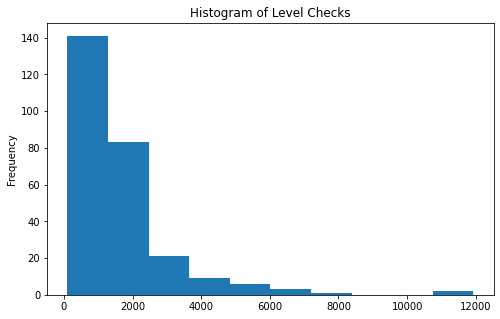

In [8]:
num_checks = df['num_checks'].value_counts(dropna=False)
num_checks.plot(
   kind="hist",
   figsize=(8,5),
   title = "Histogram of Level Checks"
)

Removing users who have not performed any level check:

In [9]:
# Printing the shape of the framework before the cleaning process:
print("Shape before cleaning: ", df.shape)

# Cleaning the data...
df = df[df['num_checks'] > 0]

# Printing the shape of the framework after the cleaning process:
print("Shape after cleaning: ", df.shape)
df.head()

Shape before cleaning:  (425731, 20)
Shape after cleaning:  (425731, 20)


,transaction_id,transaction_token,user_id,document_id,document_version,evaluation,input,start_time,commit_time,user_agent,validation,solution,type,learn_session_id,topic_id,max_num_tasks,is_closed,type_id,is_accepted,num_checks
0,1576010,a65959df-7bf0-4956-9aa7-511af281fdb5,387604.0,18FedrGurdA7jklbk0mtVA,115404,NaN,NaN,1645197218251,1.645197e+12,unknown,SKIP,NaN,NaN,111059,3250,5,0,1,NaN,11
1,563378,b5978bb1-c34f-4157-9d1f-052b451edab5,387604.0,1aRVNzqunJs6eJCo9vZiy3,70675,NaN,NaN,1615192571101,NaN,unknown,NaN,NaN,NaN,14120,3,5,1,1,1.0,11
2,1062011,411c11ae-6af2-4574-b7df-d94dac280da5,387604.0,1DI3PtzowVCafiuZCb0mEX,89020,NaN,NaN,1637146635218,NaN,unknown,NaN,NaN,NaN,70380,3,5,1,2,NaN,11
3,774545,64645a54-a4f3-4e7b-9f88-39205882d87d,387604.0,1eWCmfpLnkQ96qFQp5XixR,95079,NaN,NaN,1630399544151,1.630400e+12,unknown,SKIP,NaN,NaN,41166,3119,5,1,1,1.0,11
4,803096,37f3ad9a-ca06-43dc-9878-90599ac31f44,387604.0,1LNLRvfltpl9kmi7YOJIKV,64911,NaN,NaN,1631200106071,NaN,unknown,NaN,NaN,NaN,44450,3119,5,1,2,NaN,11


Dropping duplicates:

In [10]:
print("Shape with duplicates:", df.shape)
df = df.drop_duplicates()
print("Shape without duplicates:", df.shape)

Shape with duplicates: (425731, 20)
Shape without duplicates: (425731, 20)


Saving intermediate dataframe:

In [11]:
# Write a pandas dataframe df to gzipped CSV file
df.to_csv("data_1.csv.gz", 
           index=False, 
           compression="gzip")

### Cleaning criteria 2
Removing untrackable students: those who never did any training question or theory reading.
Justification of the cleaning decision: our goal is to predict user's success in level checks based on their regularity in time. As a consequence, we are not interested in users that have not perform any training or preparation for the level checks because we cannot measure their regularity (since they have not used the platform).

Merging `df` with `events`:

In [12]:
df = df.merge(events, on = ['user_id','transaction_token'])
df.head()

,transaction_id,transaction_token,user_id,document_id,document_version,evaluation,input,start_time,commit_time,user_agent,...,type_id,is_accepted,num_checks,event_id,timestamp,category,action,event_type,session_id,tracking_data
0,1576010,a65959df-7bf0-4956-9aa7-511af281fdb5,387604.0,18FedrGurdA7jklbk0mtVA,115404,NaN,NaN,1645197218251,1.645197e+12,unknown,...,1,NaN,11,3469683,1645197218387,SESSION,REVIEW_TASK,VIEW,111059.0,NaN
1,1576010,a65959df-7bf0-4956-9aa7-511af281fdb5,387604.0,18FedrGurdA7jklbk0mtVA,115404,NaN,NaN,1645197218251,1.645197e+12,unknown,...,1,NaN,11,3469684,1645197220545,SESSION,SKIP,CLICK,111059.0,NaN
2,1062011,411c11ae-6af2-4574-b7df-d94dac280da5,387604.0,1DI3PtzowVCafiuZCb0mEX,89020,NaN,NaN,1637146635218,NaN,unknown,...,2,NaN,11,1551821,1637146635291,SESSION,REVIEW_TASK,VIEW,70380.0,NaN
3,1062011,411c11ae-6af2-4574-b7df-d94dac280da5,387604.0,1DI3PtzowVCafiuZCb0mEX,89020,NaN,NaN,1637146635218,NaN,unknown,...,2,NaN,11,1551834,1637146648711,SESSION,CLOSE,CLICK,70380.0,NaN
4,774545,64645a54-a4f3-4e7b-9f88-39205882d87d,387604.0,1eWCmfpLnkQ96qFQp5XixR,95079,NaN,NaN,1630399544151,1.630400e+12,unknown,...,1,1.0,11,231941,1630399544249,SESSION,REVIEW_TASK,VIEW,41166.0,NaN


In [13]:
df.tail()

,transaction_id,transaction_token,user_id,document_id,document_version,evaluation,input,start_time,commit_time,user_agent,...,type_id,is_accepted,num_checks,event_id,timestamp,category,action,event_type,session_id,tracking_data
949934,1584551,7c9956b4-d2e2-4f30-9245-8155d6636bd5,404604.0,9wGXbOQkPdV6yr6aUa4ubj,89818,NaN,NaN,1645454941994,1.645455e+12,unknown,...,2,1.0,8,3509238,1645454970547,SESSION,SKIP,CLICK,112060.0,NaN
949935,1584578,7e328437-52df-4697-94e9-186844c3e269,404604.0,a1jzfZLIHDt7LzD8KKha54,39046,PARTIAL,"{""type"": ""MULTIPLE_CHOICE"", ""selections"": {""3""...",1645455097067,1.645455e+12,unknown,...,2,1.0,8,3509288,1645455097334,SESSION,REVIEW_TASK,VIEW,112060.0,NaN
949936,1584578,7e328437-52df-4697-94e9-186844c3e269,404604.0,a1jzfZLIHDt7LzD8KKha54,39046,PARTIAL,"{""type"": ""MULTIPLE_CHOICE"", ""selections"": {""3""...",1645455097067,1.645455e+12,unknown,...,2,1.0,8,3509300,1645455136634,TASK,SUBMIT_ANSWER,CLICK,112060.0,NaN
949937,1584584,48c02063-8c99-4e2c-b783-b626cf2fcfe9,404604.0,AUaU88i0ME6XdsMZWd5gp,39050,PARTIAL,"{""type"": ""MULTIPLE_CHOICE"", ""selections"": {""0""...",1645455137205,1.645461e+12,unknown,...,2,1.0,8,3509301,1645455137465,SESSION,REVIEW_TASK,VIEW,112060.0,NaN
949938,1584584,48c02063-8c99-4e2c-b783-b626cf2fcfe9,404604.0,AUaU88i0ME6XdsMZWd5gp,39050,PARTIAL,"{""type"": ""MULTIPLE_CHOICE"", ""selections"": {""0""...",1645455137205,1.645461e+12,unknown,...,2,1.0,8,3510838,1645461196870,TASK,SUBMIT_ANSWER,CLICK,112060.0,NaN


Computing the number of questions submitted by each user on the platform:

In [14]:
test_data = pd.DataFrame(df.groupby(['user_id', 'action']).size())
test_data = test_data.reset_index()
test_data = test_data[test_data['action'] == ('SUBMIT_ANSWER' or 'GO_TO_THEORY')]
test_data = test_data.rename(columns = {0 : "num_participations"}, errors = "raise")
test_data = test_data.drop(columns = ['action'])
test_data.head()

,user_id,num_participations
5,387604.0,5
16,387605.0,110
22,387608.0,38
27,387615.0,7
36,387644.0,22


Merging `df` with `test_data`:

In [15]:
df = df.merge(test_data, on = 'user_id')
df.head()

,transaction_id,transaction_token,user_id,document_id,document_version,evaluation,input,start_time,commit_time,user_agent,...,is_accepted,num_checks,event_id,timestamp,category,action,event_type,session_id,tracking_data,num_participations
0,1576010,a65959df-7bf0-4956-9aa7-511af281fdb5,387604.0,18FedrGurdA7jklbk0mtVA,115404,NaN,NaN,1645197218251,1.645197e+12,unknown,...,NaN,11,3469683,1645197218387,SESSION,REVIEW_TASK,VIEW,111059.0,NaN,5
1,1576010,a65959df-7bf0-4956-9aa7-511af281fdb5,387604.0,18FedrGurdA7jklbk0mtVA,115404,NaN,NaN,1645197218251,1.645197e+12,unknown,...,NaN,11,3469684,1645197220545,SESSION,SKIP,CLICK,111059.0,NaN,5
2,1062011,411c11ae-6af2-4574-b7df-d94dac280da5,387604.0,1DI3PtzowVCafiuZCb0mEX,89020,NaN,NaN,1637146635218,NaN,unknown,...,NaN,11,1551821,1637146635291,SESSION,REVIEW_TASK,VIEW,70380.0,NaN,5
3,1062011,411c11ae-6af2-4574-b7df-d94dac280da5,387604.0,1DI3PtzowVCafiuZCb0mEX,89020,NaN,NaN,1637146635218,NaN,unknown,...,NaN,11,1551834,1637146648711,SESSION,CLOSE,CLICK,70380.0,NaN,5
4,774545,64645a54-a4f3-4e7b-9f88-39205882d87d,387604.0,1eWCmfpLnkQ96qFQp5XixR,95079,NaN,NaN,1630399544151,1.630400e+12,unknown,...,1.0,11,231941,1630399544249,SESSION,REVIEW_TASK,VIEW,41166.0,NaN,5


Histogram of the number of *participations* performed by the users of the platform:

<AxesSubplot:title={'center':'Histogram of Participations'}, ylabel='Frequency'>

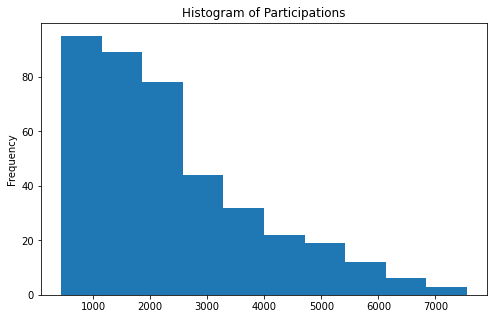

In [16]:
num_participations = df['num_participations'].value_counts(dropna=False)
num_participations.plot(
   kind="hist",
   figsize=(8,5),
   title = "Histogram of Participations"
)

Removing users who have never performed a training question or have not read any theory on the platform:

In [17]:
# Printing the shape of the framework before the cleaning process:
print("Shape before cleaning: ", df.shape)

# Cleaning the data...
df = df[df['num_participations'] > 0]

# Printing the shape of the framework after the cleaning process:
print("Shape after cleaning: ", df.shape)
df.head()

Shape before cleaning:  (948029, 28)
Shape after cleaning:  (948029, 28)


,transaction_id,transaction_token,user_id,document_id,document_version,evaluation,input,start_time,commit_time,user_agent,...,is_accepted,num_checks,event_id,timestamp,category,action,event_type,session_id,tracking_data,num_participations
0,1576010,a65959df-7bf0-4956-9aa7-511af281fdb5,387604.0,18FedrGurdA7jklbk0mtVA,115404,NaN,NaN,1645197218251,1.645197e+12,unknown,...,NaN,11,3469683,1645197218387,SESSION,REVIEW_TASK,VIEW,111059.0,NaN,5
1,1576010,a65959df-7bf0-4956-9aa7-511af281fdb5,387604.0,18FedrGurdA7jklbk0mtVA,115404,NaN,NaN,1645197218251,1.645197e+12,unknown,...,NaN,11,3469684,1645197220545,SESSION,SKIP,CLICK,111059.0,NaN,5
2,1062011,411c11ae-6af2-4574-b7df-d94dac280da5,387604.0,1DI3PtzowVCafiuZCb0mEX,89020,NaN,NaN,1637146635218,NaN,unknown,...,NaN,11,1551821,1637146635291,SESSION,REVIEW_TASK,VIEW,70380.0,NaN,5
3,1062011,411c11ae-6af2-4574-b7df-d94dac280da5,387604.0,1DI3PtzowVCafiuZCb0mEX,89020,NaN,NaN,1637146635218,NaN,unknown,...,NaN,11,1551834,1637146648711,SESSION,CLOSE,CLICK,70380.0,NaN,5
4,774545,64645a54-a4f3-4e7b-9f88-39205882d87d,387604.0,1eWCmfpLnkQ96qFQp5XixR,95079,NaN,NaN,1630399544151,1.630400e+12,unknown,...,1.0,11,231941,1630399544249,SESSION,REVIEW_TASK,VIEW,41166.0,NaN,5


Dropping duplicates:

In [18]:
print("Shape with duplicates:", df.shape)
df = df.drop_duplicates()
print("Shape without duplicates:", df.shape)

Shape with duplicates: (948029, 28)
Shape without duplicates: (948029, 28)


Saving intermediate dataframe:

In [19]:
# Write a pandas dataframe df to gzipped CSV file
df.to_csv("data_2.csv.gz", 
           index=False, 
           compression="gzip")

### Cleaning criteria 3
Removing inactive students: those who have not used the platform for several weeks with a minimum number of actions per week.

Adding `week_of_year` to the dataframe:

In [20]:
def create_week_number(d):
    return (d.isocalendar()[0]-2021)*53 + d.isocalendar()[1]-1

In [21]:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit = 'ms')
df['week'] = df['timestamp'].map(lambda x: create_week_number(x))
df['week'] -= min(df['week'])
df.head()

,transaction_id,transaction_token,user_id,document_id,document_version,evaluation,input,start_time,commit_time,user_agent,...,num_checks,event_id,timestamp,category,action,event_type,session_id,tracking_data,num_participations,week
0,1576010,a65959df-7bf0-4956-9aa7-511af281fdb5,387604.0,18FedrGurdA7jklbk0mtVA,115404,NaN,NaN,1645197218251,1.645197e+12,unknown,...,11,3469683,2022-02-18 15:13:38.387,SESSION,REVIEW_TASK,VIEW,111059.0,NaN,5,40
1,1576010,a65959df-7bf0-4956-9aa7-511af281fdb5,387604.0,18FedrGurdA7jklbk0mtVA,115404,NaN,NaN,1645197218251,1.645197e+12,unknown,...,11,3469684,2022-02-18 15:13:40.545,SESSION,SKIP,CLICK,111059.0,NaN,5,40
2,1062011,411c11ae-6af2-4574-b7df-d94dac280da5,387604.0,1DI3PtzowVCafiuZCb0mEX,89020,NaN,NaN,1637146635218,NaN,unknown,...,11,1551821,2021-11-17 10:57:15.291,SESSION,REVIEW_TASK,VIEW,70380.0,NaN,5,26
3,1062011,411c11ae-6af2-4574-b7df-d94dac280da5,387604.0,1DI3PtzowVCafiuZCb0mEX,89020,NaN,NaN,1637146635218,NaN,unknown,...,11,1551834,2021-11-17 10:57:28.711,SESSION,CLOSE,CLICK,70380.0,NaN,5,26
4,774545,64645a54-a4f3-4e7b-9f88-39205882d87d,387604.0,1eWCmfpLnkQ96qFQp5XixR,95079,NaN,NaN,1630399544151,1.630400e+12,unknown,...,11,231941,2021-08-31 08:45:44.249,SESSION,REVIEW_TASK,VIEW,41166.0,NaN,5,15


In [22]:
df.iloc[300]

transaction_id                                     1114001
transaction_token     1924e4ee-6f6f-4be1-9447-5d389aa08a98
user_id                                           387605.0
document_id                         54NBdmRqbZr9y5jrumbGGv
document_version                                     85083
evaluation                                             NaN
input                                                  NaN
start_time                                   1637914605464
commit_time                                1637914607100.0
user_agent                                         unknown
validation                                            SKIP
solution                                               NaN
type                                                   NaN
learn_session_id                                     74600
topic_id                                               957
max_num_tasks                                            5
is_closed                                               

In [23]:
df.tail()

,transaction_id,transaction_token,user_id,document_id,document_version,evaluation,input,start_time,commit_time,user_agent,...,num_checks,event_id,timestamp,category,action,event_type,session_id,tracking_data,num_participations,week
948024,1584551,7c9956b4-d2e2-4f30-9245-8155d6636bd5,404604.0,9wGXbOQkPdV6yr6aUa4ubj,89818,NaN,NaN,1645454941994,1.645455e+12,unknown,...,8,3509238,2022-02-21 14:49:30.547,SESSION,SKIP,CLICK,112060.0,NaN,4,41
948025,1584578,7e328437-52df-4697-94e9-186844c3e269,404604.0,a1jzfZLIHDt7LzD8KKha54,39046,PARTIAL,"{""type"": ""MULTIPLE_CHOICE"", ""selections"": {""3""...",1645455097067,1.645455e+12,unknown,...,8,3509288,2022-02-21 14:51:37.334,SESSION,REVIEW_TASK,VIEW,112060.0,NaN,4,41
948026,1584578,7e328437-52df-4697-94e9-186844c3e269,404604.0,a1jzfZLIHDt7LzD8KKha54,39046,PARTIAL,"{""type"": ""MULTIPLE_CHOICE"", ""selections"": {""3""...",1645455097067,1.645455e+12,unknown,...,8,3509300,2022-02-21 14:52:16.634,TASK,SUBMIT_ANSWER,CLICK,112060.0,NaN,4,41
948027,1584584,48c02063-8c99-4e2c-b783-b626cf2fcfe9,404604.0,AUaU88i0ME6XdsMZWd5gp,39050,PARTIAL,"{""type"": ""MULTIPLE_CHOICE"", ""selections"": {""0""...",1645455137205,1.645461e+12,unknown,...,8,3509301,2022-02-21 14:52:17.465,SESSION,REVIEW_TASK,VIEW,112060.0,NaN,4,41
948028,1584584,48c02063-8c99-4e2c-b783-b626cf2fcfe9,404604.0,AUaU88i0ME6XdsMZWd5gp,39050,PARTIAL,"{""type"": ""MULTIPLE_CHOICE"", ""selections"": {""0""...",1645455137205,1.645461e+12,unknown,...,8,3510838,2022-02-21 16:33:16.870,TASK,SUBMIT_ANSWER,CLICK,112060.0,NaN,4,41


Let's explore the different types of actions we have in our dataset:

In [24]:
set(df['action'])

{'CLOSE',
 'CLOSE_FEEDBACK',
 'GO_TO_BUG_REPORT',
 'GO_TO_COMMENTS',
 'GO_TO_THEORY',
 'NEXT',
 'OPEN_FEEDBACK',
 'REQUEST_HINT',
 'REVIEW_TASK',
 'SHARE',
 'SKIP',
 'SUBMIT_ANSWER',
 'VIEW_QUESTION'}

The actions list in the set above will be considered as **significant actions** (this actions are the ones that are in the `events` table but that also have a `transaction_token` associated in the same row), while we won't be interested in actions such as `LOGIN`, `LOGOUT` and `NAVIGATE_DASHBOARD` (see set of actions below).

In [25]:
set(events['action'])-set(df['action'])

{'ACCEPT_PROGRESS',
 'GO_TO_SESSION',
 'LOGIN',
 'LOGOUT',
 'NAVIGATE_DASHBOARD',
 'NAVIGATE_SURVEY',
 'PAGE_VISIT',
 'PRETEST',
 'REJECT_PROGRESS',
 'SELECT_STATISTICS',
 'SHARE_SESSION',
 'SUBMIT_SEARCH',
 'SURVEY_BANNER',
 'VIEW_SESSION_END',
 'WINDOW_CLOSE',
 'WINDOW_OPEN',
 'WINDOW_VISIBLE_FALSE',
 'WINDOW_VISIBLE_TRUE'}

Computing *significant actions* per week:

In [26]:
test_data = df[['user_id', 'week', 'action']]
# Removing data rows whose action is not significant:
# test_data = test_data[test_data['action'].isin(['GO_TO_BUG_REPORT', 'REVIEW_TASK', 'SUBMIT_ANSWER', 'VIEW_QUESTION'])]
test_data = df.groupby(['user_id', 'week']).size()
test_data = pd.DataFrame(test_data)
test_data = test_data.reset_index()
test_data = test_data.rename(columns = {0 : "num_actions_per_week"}, errors = "raise")
test_data.head()

,user_id,week,num_actions_per_week
0,387604.0,5,3
1,387604.0,6,16
2,387604.0,13,2
3,387604.0,15,29
4,387604.0,16,5


Sorting the values of the dataframe `test_data`:

In [27]:
test_data = test_data.sort_values(['user_id', 'week'])
test_data.head()

,user_id,week,num_actions_per_week
0,387604.0,5,3
1,387604.0,6,16
2,387604.0,13,2
3,387604.0,15,29
4,387604.0,16,5


Merging `df` with `test_data`:

In [28]:
df = df.merge(test_data, on = ['user_id', 'week'])
df.head()

,transaction_id,transaction_token,user_id,document_id,document_version,evaluation,input,start_time,commit_time,user_agent,...,event_id,timestamp,category,action,event_type,session_id,tracking_data,num_participations,week,num_actions_per_week
0,1576010,a65959df-7bf0-4956-9aa7-511af281fdb5,387604.0,18FedrGurdA7jklbk0mtVA,115404,NaN,NaN,1645197218251,1.645197e+12,unknown,...,3469683,2022-02-18 15:13:38.387,SESSION,REVIEW_TASK,VIEW,111059.0,NaN,5,40,7
1,1576010,a65959df-7bf0-4956-9aa7-511af281fdb5,387604.0,18FedrGurdA7jklbk0mtVA,115404,NaN,NaN,1645197218251,1.645197e+12,unknown,...,3469684,2022-02-18 15:13:40.545,SESSION,SKIP,CLICK,111059.0,NaN,5,40,7
2,1576012,379dad17-2d6f-42f3-b6f0-68a39664733b,387604.0,1taQDeFXg1E9GxbT0YApJU,115407,NaN,NaN,1645197222948,NaN,unknown,...,3469687,2022-02-18 15:13:43.057,SESSION,REVIEW_TASK,VIEW,111059.0,NaN,5,40,7
3,1576009,5094da67-0959-46b4-bb4a-03b5d55259fa,387604.0,81qKZ40TTAx6YsQPzKE5kx,116432,NaN,NaN,1645197210317,1.645197e+12,unknown,...,3469676,2022-02-18 15:13:30.415,SESSION,REVIEW_TASK,VIEW,111059.0,NaN,5,40,7
4,1576009,5094da67-0959-46b4-bb4a-03b5d55259fa,387604.0,81qKZ40TTAx6YsQPzKE5kx,116432,NaN,NaN,1645197210317,1.645197e+12,unknown,...,3469682,2022-02-18 15:13:37.975,SESSION,SKIP,CLICK,111059.0,NaN,5,40,7


Dropping duplicates:

In [29]:
print("Shape with duplicates:", df.shape)
df = df.drop_duplicates()
print("Shape without duplicates:", df.shape)

Shape with duplicates: (948029, 30)
Shape without duplicates: (948029, 30)


Saving intermediate dataframe:

In [30]:
# Write a pandas dataframe df to gzipped CSV file
df.to_csv("data_3_1.csv.gz", 
           index=False, 
           compression="gzip")

Now, I will summarize the data using a boxplot: 

<AxesSubplot:xlabel='num_actions_per_week'>

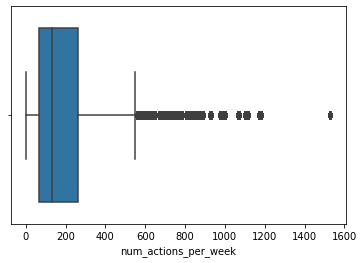

In [31]:
sns.boxplot(x = df['num_actions_per_week'])

We can appreciate in the boxplot the presence of outliers. However, we don't want to remove users with a high activity in the platform, as they can provide us with useful information in our research.

As we can appreciate in the plot, there are not outliers in the left side of the plot.

Now, I will apply the Local Outlier Factor method to detect outliers values of the column `num_actions_per_week`:

In [32]:
# Import the required library
from sklearn.neighbors import LocalOutlierFactor

# Define LOF class
lof = LocalOutlierFactor() # consider playing around with 'n_neighbors' parameter

test_data = df[['user_id', 'week', 'num_actions_per_week']]

# Predict whether the numerical columns are outlier or not
y_pred = lof.fit_predict(test_data)

# Select all rows that are not outliers
mask = y_pred != -1
print("Shape with local outliers:", test_data.shape)
test_data_clean = test_data[mask]
test_data_clean.head()
print("Shape without local outliers:", test_data.shape)

Shape with local outliers: (948029, 3)
Shape without local outliers: (948029, 3)


It turns out that none of the rows have been deleted using this method.

Dropping duplicates:

In [33]:
print("Shape with duplicates:", df.shape)
df = df.drop_duplicates()
print("Shape without duplicates:", df.shape)

Shape with duplicates: (948029, 30)
Shape without duplicates: (948029, 30)


Saving intermediate dataframe:

In [34]:
# Write a pandas dataframe df to gzipped CSV file
df.to_csv("data_3_2.csv.gz", 
           index=False, 
           compression="gzip")

In [35]:
# Printing the shape of the framework before the cleaning:
print("Shape before cleaning: ", df.shape)

# Cleaning process
df = df[df['num_actions_per_week'] > 4]
df.head()

# Printing the shape of the framework after the cleaning:
print("Shape after cleaning: ", df.shape)
df.head()

Shape before cleaning:  (948029, 30)
Shape after cleaning:  (944645, 30)


,transaction_id,transaction_token,user_id,document_id,document_version,evaluation,input,start_time,commit_time,user_agent,...,event_id,timestamp,category,action,event_type,session_id,tracking_data,num_participations,week,num_actions_per_week
0,1576010,a65959df-7bf0-4956-9aa7-511af281fdb5,387604.0,18FedrGurdA7jklbk0mtVA,115404,NaN,NaN,1645197218251,1.645197e+12,unknown,...,3469683,2022-02-18 15:13:38.387,SESSION,REVIEW_TASK,VIEW,111059.0,NaN,5,40,7
1,1576010,a65959df-7bf0-4956-9aa7-511af281fdb5,387604.0,18FedrGurdA7jklbk0mtVA,115404,NaN,NaN,1645197218251,1.645197e+12,unknown,...,3469684,2022-02-18 15:13:40.545,SESSION,SKIP,CLICK,111059.0,NaN,5,40,7
2,1576012,379dad17-2d6f-42f3-b6f0-68a39664733b,387604.0,1taQDeFXg1E9GxbT0YApJU,115407,NaN,NaN,1645197222948,NaN,unknown,...,3469687,2022-02-18 15:13:43.057,SESSION,REVIEW_TASK,VIEW,111059.0,NaN,5,40,7
3,1576009,5094da67-0959-46b4-bb4a-03b5d55259fa,387604.0,81qKZ40TTAx6YsQPzKE5kx,116432,NaN,NaN,1645197210317,1.645197e+12,unknown,...,3469676,2022-02-18 15:13:30.415,SESSION,REVIEW_TASK,VIEW,111059.0,NaN,5,40,7
4,1576009,5094da67-0959-46b4-bb4a-03b5d55259fa,387604.0,81qKZ40TTAx6YsQPzKE5kx,116432,NaN,NaN,1645197210317,1.645197e+12,unknown,...,3469682,2022-02-18 15:13:37.975,SESSION,SKIP,CLICK,111059.0,NaN,5,40,7


In [36]:
df.tail()

,transaction_id,transaction_token,user_id,document_id,document_version,evaluation,input,start_time,commit_time,user_agent,...,event_id,timestamp,category,action,event_type,session_id,tracking_data,num_participations,week,num_actions_per_week
948024,1584551,7c9956b4-d2e2-4f30-9245-8155d6636bd5,404604.0,9wGXbOQkPdV6yr6aUa4ubj,89818,NaN,NaN,1645454941994,1.645455e+12,unknown,...,3509238,2022-02-21 14:49:30.547,SESSION,SKIP,CLICK,112060.0,NaN,4,41,17
948025,1584578,7e328437-52df-4697-94e9-186844c3e269,404604.0,a1jzfZLIHDt7LzD8KKha54,39046,PARTIAL,"{""type"": ""MULTIPLE_CHOICE"", ""selections"": {""3""...",1645455097067,1.645455e+12,unknown,...,3509288,2022-02-21 14:51:37.334,SESSION,REVIEW_TASK,VIEW,112060.0,NaN,4,41,17
948026,1584578,7e328437-52df-4697-94e9-186844c3e269,404604.0,a1jzfZLIHDt7LzD8KKha54,39046,PARTIAL,"{""type"": ""MULTIPLE_CHOICE"", ""selections"": {""3""...",1645455097067,1.645455e+12,unknown,...,3509300,2022-02-21 14:52:16.634,TASK,SUBMIT_ANSWER,CLICK,112060.0,NaN,4,41,17
948027,1584584,48c02063-8c99-4e2c-b783-b626cf2fcfe9,404604.0,AUaU88i0ME6XdsMZWd5gp,39050,PARTIAL,"{""type"": ""MULTIPLE_CHOICE"", ""selections"": {""0""...",1645455137205,1.645461e+12,unknown,...,3509301,2022-02-21 14:52:17.465,SESSION,REVIEW_TASK,VIEW,112060.0,NaN,4,41,17
948028,1584584,48c02063-8c99-4e2c-b783-b626cf2fcfe9,404604.0,AUaU88i0ME6XdsMZWd5gp,39050,PARTIAL,"{""type"": ""MULTIPLE_CHOICE"", ""selections"": {""0""...",1645455137205,1.645461e+12,unknown,...,3510838,2022-02-21 16:33:16.870,TASK,SUBMIT_ANSWER,CLICK,112060.0,NaN,4,41,17


*Definition:* A **significant week** of a particular user is a week in which that user has performed at least $2$ (the closer integer to the lower bound we have defined aboved) significant actions. Note that we have just deleted of our dataframe of the weeks that are not significant.

Computing the total number of weeks that each user has been actived in the platform:

In [37]:
test_data = df[['user_id', 'week']].drop_duplicates()
test_data.head()

,user_id,week
0,387604.0,40
7,387604.0,26
50,387604.0,15
79,387604.0,16
87,387604.0,6


In [38]:
test_data = pd.DataFrame(test_data.groupby(['user_id']).size()).reset_index()
test_data = test_data.rename(columns = {0 : "num_weeks_per_user"}, errors = "raise")
test_data.head()

,user_id,num_weeks_per_user
0,387604.0,6
1,387605.0,13
2,387608.0,5
3,387615.0,1
4,387644.0,2


In [39]:
test_data.tail()

,user_id,num_weeks_per_user
4916,404583.0,1
4917,404585.0,1
4918,404586.0,1
4919,404592.0,1
4920,404604.0,1


Merging `df` with `test_data`:

In [40]:
df = df.merge(test_data, on = 'user_id')
df.head()

,transaction_id,transaction_token,user_id,document_id,document_version,evaluation,input,start_time,commit_time,user_agent,...,timestamp,category,action,event_type,session_id,tracking_data,num_participations,week,num_actions_per_week,num_weeks_per_user
0,1576010,a65959df-7bf0-4956-9aa7-511af281fdb5,387604.0,18FedrGurdA7jklbk0mtVA,115404,NaN,NaN,1645197218251,1.645197e+12,unknown,...,2022-02-18 15:13:38.387,SESSION,REVIEW_TASK,VIEW,111059.0,NaN,5,40,7,6
1,1576010,a65959df-7bf0-4956-9aa7-511af281fdb5,387604.0,18FedrGurdA7jklbk0mtVA,115404,NaN,NaN,1645197218251,1.645197e+12,unknown,...,2022-02-18 15:13:40.545,SESSION,SKIP,CLICK,111059.0,NaN,5,40,7,6
2,1576012,379dad17-2d6f-42f3-b6f0-68a39664733b,387604.0,1taQDeFXg1E9GxbT0YApJU,115407,NaN,NaN,1645197222948,NaN,unknown,...,2022-02-18 15:13:43.057,SESSION,REVIEW_TASK,VIEW,111059.0,NaN,5,40,7,6
3,1576009,5094da67-0959-46b4-bb4a-03b5d55259fa,387604.0,81qKZ40TTAx6YsQPzKE5kx,116432,NaN,NaN,1645197210317,1.645197e+12,unknown,...,2022-02-18 15:13:30.415,SESSION,REVIEW_TASK,VIEW,111059.0,NaN,5,40,7,6
4,1576009,5094da67-0959-46b4-bb4a-03b5d55259fa,387604.0,81qKZ40TTAx6YsQPzKE5kx,116432,NaN,NaN,1645197210317,1.645197e+12,unknown,...,2022-02-18 15:13:37.975,SESSION,SKIP,CLICK,111059.0,NaN,5,40,7,6


Dropping duplicates:

In [41]:
print("Shape with duplicates:", df.shape)
df = df.drop_duplicates()
print("Shape without duplicates:", df.shape)

Shape with duplicates: (944645, 31)
Shape without duplicates: (944645, 31)


Saving intermediate dataframe:

In [42]:
# Write a pandas dataframe df to gzipped CSV file
df.to_csv("data_3_3.csv.gz", 
           index=False, 
           compression="gzip")

Now, I will summarize the data using a boxplot:

<AxesSubplot:xlabel='num_weeks_per_user'>

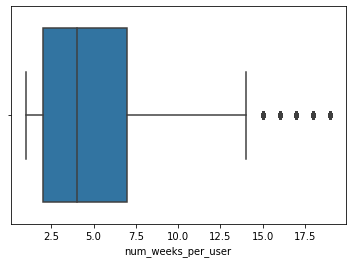

In [43]:
sns.boxplot(x = df['num_weeks_per_user'])

We can appreciate in the boxplot the presence of outliers. However, we don't want to remove users with a high activity in the platform, as they can provide us with useful information in our research.

As we can appreciate in the plot, there are not outliers in the left side of the plot.

Now, I will apply the Local Outlier Factor method to detect outliers values of the column `num_weeks_per_user`:

In [44]:
# Import the required library
from sklearn.neighbors import LocalOutlierFactor

# Define LOF class
lof = LocalOutlierFactor(n_neighbors = 2) # consider playing around with 'n_neighbors' parameter

test_data = df[['user_id', 'num_weeks_per_user']]

# Predict whether the numerical columns are outlier or not
y_pred = lof.fit_predict(test_data)

# Select all rows that are not outliers
mask = y_pred != -1
print("Shape with local outliers:", test_data.shape)
test_data_clean = test_data[mask]
test_data_clean.head()
print("Shape without local outliers:", test_data.shape)

Shape with local outliers: (944645, 2)
Shape without local outliers: (944645, 2)


It turns out that none of the rows have been deleted using this method.

Importing intermediate file:

In [46]:
# df = pd.read_csv('{}/data_3_3.csv.gz'.format(DATA_DIR))

Deleting rows corresponding to users with less than $2$ significant weeks (since we are interested in doing a time series analysis):

In [47]:
# Printing the shape of the framework before the cleaning:
print("Shape before cleaning: ", df.shape)

# Cleaning process...
df = df[df['num_weeks_per_user'] > 1]

# Printing the shape of the framework after the cleaning process:
print("Shape after cleaning: ", df.shape)
df.head()

Shape before cleaning:  (944645, 31)
Shape after cleaning:  (790425, 31)


,transaction_id,transaction_token,user_id,document_id,document_version,evaluation,input,start_time,commit_time,user_agent,...,timestamp,category,action,event_type,session_id,tracking_data,num_participations,week,num_actions_per_week,num_weeks_per_user
0,1576010,a65959df-7bf0-4956-9aa7-511af281fdb5,387604.0,18FedrGurdA7jklbk0mtVA,115404,NaN,NaN,1645197218251,1.645197e+12,unknown,...,2022-02-18 15:13:38.387,SESSION,REVIEW_TASK,VIEW,111059.0,NaN,5,40,7,6
1,1576010,a65959df-7bf0-4956-9aa7-511af281fdb5,387604.0,18FedrGurdA7jklbk0mtVA,115404,NaN,NaN,1645197218251,1.645197e+12,unknown,...,2022-02-18 15:13:40.545,SESSION,SKIP,CLICK,111059.0,NaN,5,40,7,6
2,1576012,379dad17-2d6f-42f3-b6f0-68a39664733b,387604.0,1taQDeFXg1E9GxbT0YApJU,115407,NaN,NaN,1645197222948,NaN,unknown,...,2022-02-18 15:13:43.057,SESSION,REVIEW_TASK,VIEW,111059.0,NaN,5,40,7,6
3,1576009,5094da67-0959-46b4-bb4a-03b5d55259fa,387604.0,81qKZ40TTAx6YsQPzKE5kx,116432,NaN,NaN,1645197210317,1.645197e+12,unknown,...,2022-02-18 15:13:30.415,SESSION,REVIEW_TASK,VIEW,111059.0,NaN,5,40,7,6
4,1576009,5094da67-0959-46b4-bb4a-03b5d55259fa,387604.0,81qKZ40TTAx6YsQPzKE5kx,116432,NaN,NaN,1645197210317,1.645197e+12,unknown,...,2022-02-18 15:13:37.975,SESSION,SKIP,CLICK,111059.0,NaN,5,40,7,6


In [48]:
final_df = df.drop(columns = ['transaction_id', 'transaction_token', 'document_id', 'document_version', 'user_agent', 'validation', 'solution', 'type', 'learn_session_id', 'topic_id', 'is_closed', 'type_id', 'is_accepted', 'event_id', 'session_id', 'tracking_data'])

I have not deleted `start_time` and `commit_time` because it may be interesting to know the amount of time a user has spent performing an action.

In [49]:
final_df.head()

,user_id,evaluation,input,start_time,commit_time,max_num_tasks,num_checks,timestamp,category,action,event_type,num_participations,week,num_actions_per_week,num_weeks_per_user
0,387604.0,NaN,NaN,1645197218251,1.645197e+12,5,11,2022-02-18 15:13:38.387,SESSION,REVIEW_TASK,VIEW,5,40,7,6
1,387604.0,NaN,NaN,1645197218251,1.645197e+12,5,11,2022-02-18 15:13:40.545,SESSION,SKIP,CLICK,5,40,7,6
2,387604.0,NaN,NaN,1645197222948,NaN,5,11,2022-02-18 15:13:43.057,SESSION,REVIEW_TASK,VIEW,5,40,7,6
3,387604.0,NaN,NaN,1645197210317,1.645197e+12,5,11,2022-02-18 15:13:30.415,SESSION,REVIEW_TASK,VIEW,5,40,7,6
4,387604.0,NaN,NaN,1645197210317,1.645197e+12,5,11,2022-02-18 15:13:37.975,SESSION,SKIP,CLICK,5,40,7,6


I am dropping `evaluation` and `input` columns because we are not interested in whether a question is correct or not but in the result obtain in the whole level check.

In [50]:
final_df = df.drop(columns = ['evaluation', 'input', 'event_type'])
final_df = final_df[['user_id', 'timestamp', 'week', 'category', 'action', 'start_time', 'commit_time', 'max_num_tasks', 'num_checks', 'num_participations', 'num_actions_per_week', 'num_weeks_per_user']]

In [51]:
final_df.head()

,user_id,timestamp,week,category,action,start_time,commit_time,max_num_tasks,num_checks,num_participations,num_actions_per_week,num_weeks_per_user
0,387604.0,2022-02-18 15:13:38.387,40,SESSION,REVIEW_TASK,1645197218251,1.645197e+12,5,11,5,7,6
1,387604.0,2022-02-18 15:13:40.545,40,SESSION,SKIP,1645197218251,1.645197e+12,5,11,5,7,6
2,387604.0,2022-02-18 15:13:43.057,40,SESSION,REVIEW_TASK,1645197222948,NaN,5,11,5,7,6
3,387604.0,2022-02-18 15:13:30.415,40,SESSION,REVIEW_TASK,1645197210317,1.645197e+12,5,11,5,7,6
4,387604.0,2022-02-18 15:13:37.975,40,SESSION,SKIP,1645197210317,1.645197e+12,5,11,5,7,6


Making sure there are no duplicates lines in the data:

In [52]:
print("Shape with duplicates:", df.shape)
final_df = final_df.drop_duplicates()
print("Shape without duplicates:", df.shape)

Shape with duplicates: (790425, 31)
Shape without duplicates: (790425, 31)


Saving the final version of the data:

In [53]:
# Write a pandas dataframe df to gzipped CSV file
final_df.to_csv("data.csv.gz", 
           index=False, 
           compression="gzip")